- Similar to umap_kmeans
- Includes tuning of umap and cluster params

Results:
- K = 13 gives the best silhouette score.
- Elbow point is around k=5 ++

In [1]:
# Imports

from pathlib import Path
from collections import Counter
import re
import json

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
import hdbscan
import umap.umap_ as umap
import yake

from tqdm import tqdm


In [2]:
# Paths

data_path = Path("../../data/short-raw-refs-abs")
processed_abstracts_path = Path("../../data/processed/abstracts")
save_path = processed_abstracts_path / "umap_kmean_tuned"


# Ensure directories exist
for p in [data_path, processed_abstracts_path, save_path]:
    p.mkdir(parents=True, exist_ok=True)

print("All directories verified/created.")

All directories verified/created.


In [3]:
# Load abstracts dataset

abstracts_path = processed_abstracts_path / "abstracts.csv"
df = pd.read_csv(abstracts_path)

print(f"Loaded {len(df)} abstracts from {df['query_id'].nunique()} queries.")
df.head()

Loaded 52290 abstracts from 24 queries.


,query_id,eid,doi,title,abstract,clean_abs
0,ml_anomaly_detection_production,2-s2.0-105018574505,10.1016/j.measurement.2025.119261,Distillation anomaly and fault detection based...,© 2025 The Author(s)The detection of anomalies...,"Indeed, highly efficient systems do not always..."
1,ml_anomaly_detection_production,2-s2.0-105019192533,10.1007/978-3-032-06118-8_30,From Lab to Factory: Pitfalls and Guidelines f...,"© The Author(s), under exclusive license to Sp...",The detection and localization of quality-rela...
2,ml_anomaly_detection_production,2-s2.0-105016669957,10.1007/978-3-032-04200-2_5,Intelligent Defect Detection for Manufacturing...,"© The Author(s), under exclusive license to Sp...","In modern Industry, I4.0, artificial intellige..."
3,ml_anomaly_detection_production,2-s2.0-85218693791,10.1038/s41598-025-90810-w,Hybrid machine learning framework for predicti...,© The Author(s) 2025.The critical necessity fo...,The critical necessity for sophisticated predi...
4,ml_anomaly_detection_production,2-s2.0-105018301117,10.1016/j.comnet.2025.111753,BGP anomaly detection using the raw internet t...,© 2025 The AuthorsThe Border Gateway Protocol ...,"Hence, detecting any anomaly concerning BGP an..."


In [4]:
# Count how many rows each query_id has
query_counts = df["query_id"].value_counts().to_dict()

# Create a copy and map the counts to each row
df = df.copy()
df["query_size"] = df["query_id"].map(query_counts)

# Sort so that query groups with fewer rows are prioritized
df_sorted = df.sort_values(by="query_size", ascending=True)

# Remove duplicate DOIs, keeping the one in the smallest query group
df_dedup = df_sorted.drop_duplicates(subset="doi", keep="first").drop(columns=["query_size"])

# Print results
print("Original dataset size:", len(df))
print("After removing duplicates:", len(df_dedup))
print("Remaining duplicate DOIs:", df_dedup["doi"].duplicated().sum())

df = df_dedup

Original dataset size: 52290
After removing duplicates: 33130
Remaining duplicate DOIs: 0


In [5]:
model = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")

In [6]:
tokenizer = model.tokenizer  # tokenizer associated with MPNet model
max_len = model.get_max_seq_length()  # typically 384 for MPNet

def embed_with_chunking(text):
    tokens = tokenizer.tokenize(text)

    # If below limit -> embed normally
    if len(tokens) <= max_len:
        return model.encode(
            text,
            convert_to_numpy=True,
            normalize_embeddings=True,
        )

    # Split into chunks that fit model's input size
    chunks = [
        tokenizer.convert_tokens_to_string(tokens[i:i+max_len])
        for i in range(0, len(tokens), max_len)
    ]

    # Embed each chunk and average
    chunk_embeddings = model.encode(
        chunks,
        convert_to_numpy=True,
        normalize_embeddings=True,
    )
    return np.mean(chunk_embeddings, axis=0)


# Batch embedding loop with chunking 

texts = df["clean_abs"].astype(str).tolist()
batch_size = 512

embeddings = []

for start in tqdm(range(0, len(texts), batch_size), desc="Embedding abstracts"):
    batch = texts[start:start+batch_size]

    batch_emb = [embed_with_chunking(text) for text in batch]
    embeddings.append(np.vstack(batch_emb))

embeddings = np.vstack(embeddings)

print("Embedding matrix shape:", embeddings.shape)


Embedding abstracts: 100%|██████████| 65/65 [06:59<00:00,  6.45s/it]

Embedding matrix shape: (33130, 768)


In [7]:
# Save embeddings to .npy file
emb_path = save_path / "abstract_embeddings.npy"
np.save(emb_path, embeddings)
print("Saved embeddings to:", emb_path)


Saved embeddings to: ../../data/processed/abstracts/umap_kmean_tuned/abstract_embeddings.npy


In [8]:
# Load embeddings back
embeddings = np.load(save_path / "abstract_embeddings.npy")

In [ ]:
# Reduce embedding dimensionality with UMAP

umap_model = umap.UMAP(
    n_neighbors=30,
    min_dist=0.1,
    n_components=2,
    metric="cosine",
    random_state=42
)

umap_coords = umap_model.fit_transform(embeddings)
df["umap_x"] = umap_coords[:,0]
df["umap_y"] = umap_coords[:,1]

print("UMAP projection complete.")


/cluster/home/mbergst/.venvs/ml-catalogue/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP projection complete.


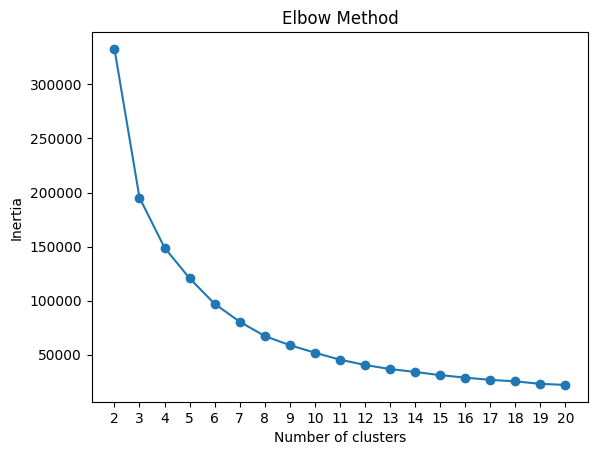

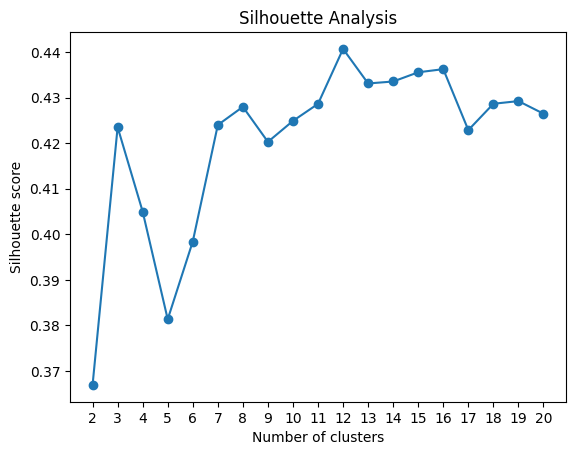

kmeans_cluster
0     2341
1     3423
2     2230
3     1839
4     2277
5     3783
6     1516
7     3349
8     4103
9     3174
10     758
11    1464
12    2873
Name: count, dtype: int64


In [10]:
# UMAP output used for clustering
X = umap_coords

# Test different numbers of clusters
k_values = range(2, 21)

# Elbow method
inertias = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)

# Plot inertia
plt.figure()
plt.plot(list(k_values), inertias, marker="o")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.xticks(list(k_values))
plt.show()

# Silhouette method
silhouette_scores = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X)
    score = silhouette_score(X, labels)
    silhouette_scores.append(score)

# Plot silhouette score
plt.figure()
plt.plot(list(k_values), silhouette_scores, marker="o")
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette score")
plt.title("Silhouette Analysis")
plt.xticks(list(k_values))
plt.show()

# Example: apply chosen number of clusters
best_k = 13
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X)

# Add labels to dataframe
df["kmeans_cluster"] = kmeans_labels
print(df["kmeans_cluster"].value_counts().sort_index())


In [11]:
# X = embedding matrix
n_neighbors = 11  # 1 = self + 10 nearest others

nbrs = NearestNeighbors(
    n_neighbors=n_neighbors,
    metric="euclidean"
).fit(X)

distances, _ = nbrs.kneighbors(X)

# Exclude distance to self (first column = 0)
avg_knn_dist = distances[:, 1:].mean(axis=1)

df["avg_knn_dist"] = avg_knn_dist

print(df["avg_knn_dist"].describe())
df.nlargest(10, "avg_knn_dist")[["avg_knn_dist"]]

count    33130.000000
mean         0.047968
std          0.028791
min          0.000688
25%          0.029668
50%          0.041945
75%          0.058978
max          0.430253
Name: avg_knn_dist, dtype: float64


,avg_knn_dist
17000,0.430253
45953,0.414344
25748,0.388886
30203,0.387572
35512,0.372989
16446,0.363251
37376,0.362943
48245,0.343425
32339,0.336754
34182,0.329147


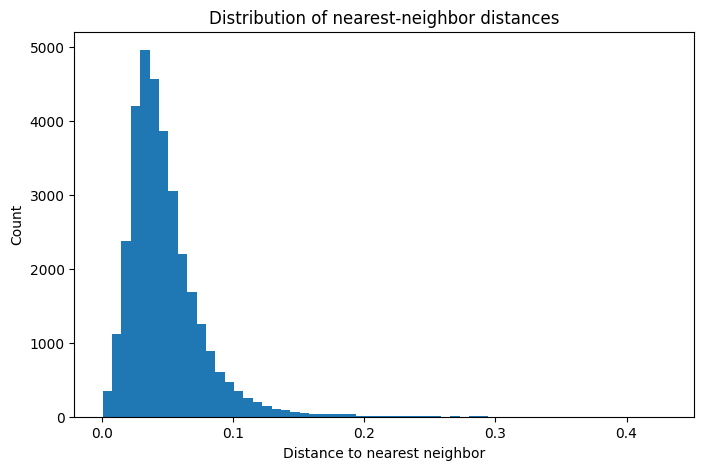

In [13]:
plt.figure(figsize=(8, 5))
plt.hist(df["avg_knn_dist"], bins=60)
plt.xlabel("Distance to nearest neighbor")
plt.ylabel("Count")
plt.title("Distribution of nearest-neighbor distances")
plt.show()


In [14]:
# Apply chosen number of clusters
k = 13
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X)

# Add labels to dataframe
df["kmeans_cluster"] = kmeans_labels
print(df["kmeans_cluster"].value_counts().sort_index())

kmeans_cluster
0     2341
1     3423
2     2230
3     1839
4     2277
5     3783
6     1516
7     3349
8     4103
9     3174
10     758
11    1464
12    2873
Name: count, dtype: int64


In [15]:
# Save extended dataset with phase information

out_path = save_path / "abstracts_with_clusters.csv"
df.to_csv(out_path, index=False)
print(f"Saved dataset with clusters to: {out_path}")

Saved dataset with clusters to: ../../data/processed/abstracts/umap_kmean_tuned/abstracts_with_clusters.csv


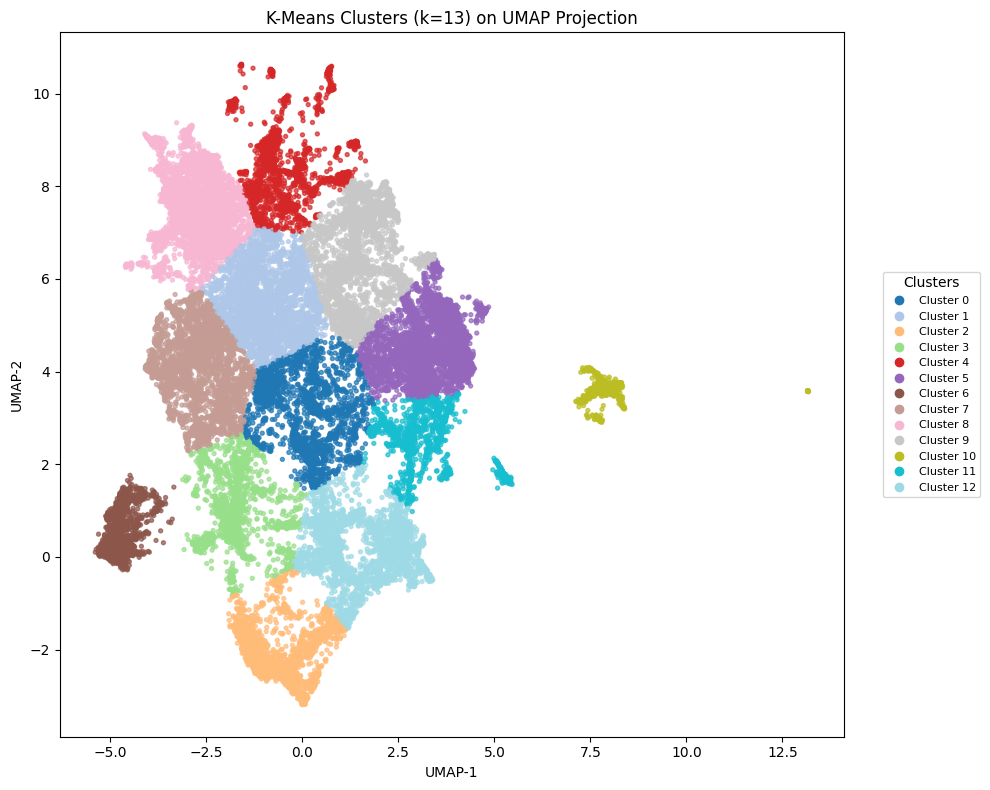

In [16]:
# Plot K-Means clusters on UMAP projection

cluster_ids = df["kmeans_cluster"].unique()
cluster_ids_sorted = sorted(cluster_ids)  # ensure consistent order

plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    df["umap_x"], df["umap_y"],
    c=df["kmeans_cluster"],
    cmap="tab20",
    s=8,
    alpha=0.7
)

# Create legend handles for clusters
handles = []
for cid in cluster_ids_sorted:
    handles.append(
        plt.Line2D(
            [], [], marker="o", linestyle="",
            color=scatter.cmap(scatter.norm(cid)),
            label=f"Cluster {cid}"  
        )
    )

plt.legend(
    handles=handles,
    title="Clusters",
    bbox_to_anchor=(1.05, 0.5),
    loc="center left",
    borderaxespad=0.,
    fontsize=8
)

plt.title(f"K-Means Clusters (k={k}) on UMAP Projection")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.tight_layout()
plt.show()


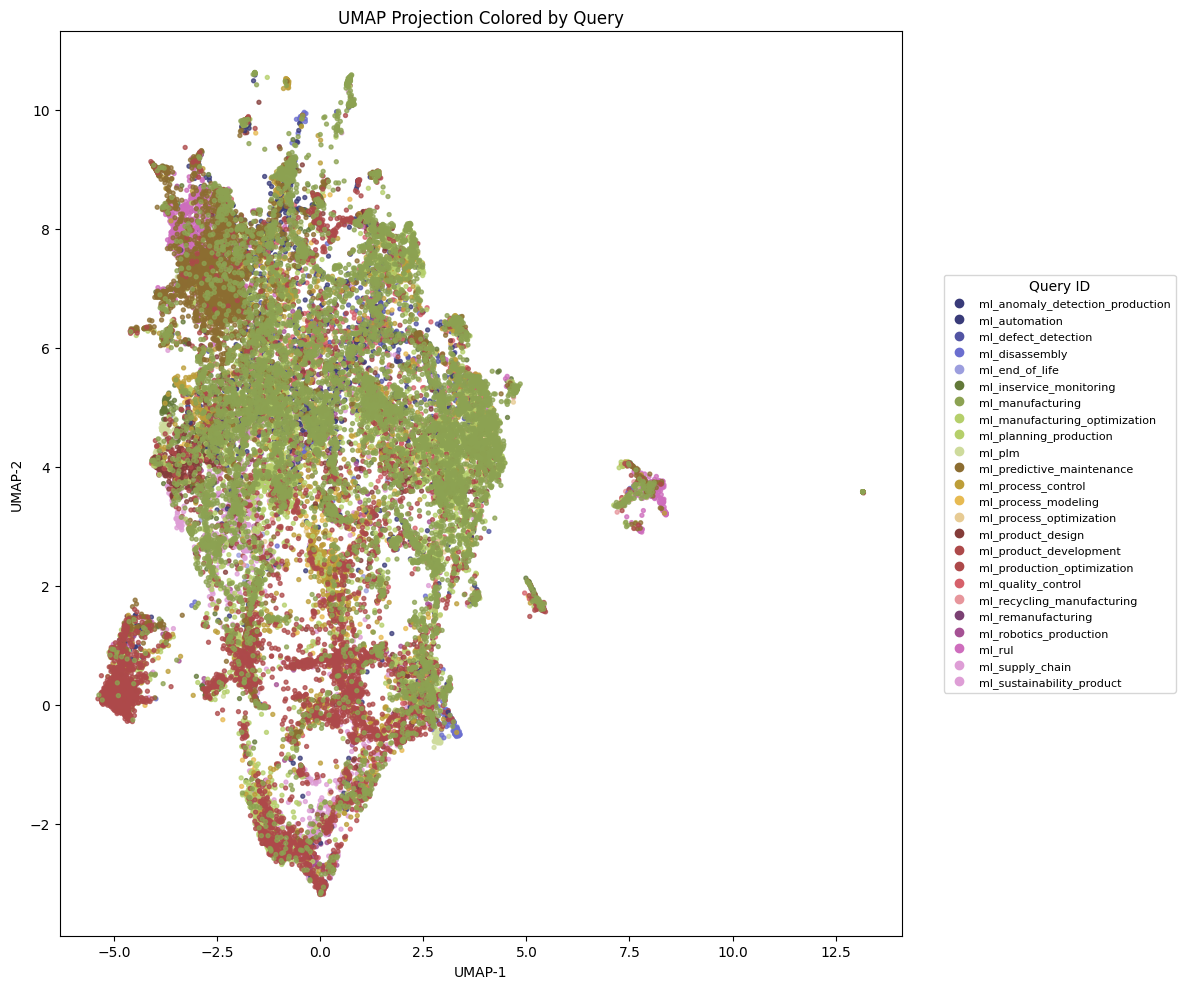

In [17]:
# Plot query_id distribution on UMAP projection

# Assign an integer color index to each query_id
query_ids = df["query_id"].astype("category")
query_labels = query_ids.cat.codes  # numeric mapping

plt.figure(figsize=(12, 10))
scatter = plt.scatter(
    df["umap_x"], df["umap_y"],
    c=query_labels,
    cmap="tab20b",   # adjust depending on number of queries (>20 => use tab20b + tab20c)
    s=8,
    alpha=0.75
)

# Legend mapping numeric labels to query_id names
handles = []
for code, name in enumerate(query_ids.cat.categories):
    handles.append(
        plt.Line2D([], [], marker="o", linestyle="", 
                   color=scatter.cmap(scatter.norm(code)), label=name)
    )

plt.legend(
    handles=handles,
    title="Query ID",
    bbox_to_anchor=(1.05, 0.5),
    loc="center left",
    borderaxespad=0.,
    fontsize=8
)

plt.title("UMAP Projection Colored by Query")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.tight_layout()
plt.show()

In [18]:
domain_stopwords = {
    # Generic ML terms
    "machine learning", "ml", "deep learning", "data", "dataset", "model",
    "models", "method", "methods", "technique", "techniques", 'machine',
    "approach", "algorithm", "algorithms", "neural network",
    "artificial neural network", "support vector machine",
    "random forest", "learning approach", "learning algorithms",
    "deep learning models", "convolutional neural network", 'machine learning approach', 
    'machine learning techniques', 'machine learning models', 'machine learning algorithms', 'machine learning methods', 
    'machine learning approach', 'neural network model', 'Support Vector Regression', 'extreme learning machine', 
    'learning models', 'advanced machine learning', 'machine learning tools', 'ai',
    

    # Publisher names + garbage
    "springer nature switzerland", "springer nature singapore",
    "elsevier", "ieee", "wiley", "mdpi",
    
    "based", 'system', 'systems', 'using', 'paper', 'tool'
}

In [19]:
# kw_extractor = yake.KeywordExtractor(
#     lan="en",
#     n=3,  # max length of keyword: allows bigrams & trigrams
#     top=20,
#     dedupLim=0.3
# )

# def get_cluster_keywords(cluster_id, top_k=10):
#     texts = df[df["kmeans_cluster"] == cluster_id]["clean_abs"].tolist()
#     full_text = " ".join(texts)
    
#     keywords = kw_extractor.extract_keywords(full_text)
#     keywords = [
#         kw for kw, score in sorted(keywords, key=lambda x: x[1])
#         if kw.lower() not in domain_stopwords
#     ]
    
#     return keywords[:top_k]

# for cid in range(k):
#     print(f"\nCluster {cid}:")
#     print(get_cluster_keywords(cid, 12))



In [20]:
# Fit TF-IDF on all abstracts once
vectorizer = TfidfVectorizer(
    max_df=0.8,
    min_df=5,
    ngram_range=(1, 3),
    stop_words="english"
)
X = vectorizer.fit_transform(df["clean_abs"].astype(str))
feature_names = np.array(vectorizer.get_feature_names_out())


In [21]:
# Generate keywords for each cluster from TF-IDF score

def get_cluster_tfidf_keywords(cluster_id, top_k=15):
    # Boolean mask as numpy array (needed for sparse matrix indexing)
    mask = (df["kmeans_cluster"] == cluster_id).values
    if mask.sum() == 0:
        return []

    X_cluster = X[mask]

    # Mean TF-IDF score per term in this cluster
    mean_tfidf = np.asarray(X_cluster.mean(axis=0)).ravel()
    top_idx = mean_tfidf.argsort()[::-1]

    keywords = []
    for idx in top_idx:
        kw = feature_names[idx].lower()

        # Skip domain-specific stopwords
        if kw in domain_stopwords:
            continue

        keywords.append(kw)
        if len(keywords) == top_k:
            break

    return keywords


# Generate keywords for all clusters
cluster_keywords = {}
for cid in range(k):
    kws = get_cluster_tfidf_keywords(cid, top_k=12)
    cluster_keywords[cid] = kws
    print(f"\nCluster {cid}:")
    print(kws)



Cluster 0:
['control', 'process', 'scheduling', 'optimization', 'production', 'proposed', 'problem', 'reinforcement learning', 'reinforcement', 'time', 'rl', 'performance']

Cluster 1:
['manufacturing', 'industry', 'industrial', 'digital', 'process', 'production', 'smart', 'quality', 'control', 'iot', 'technologies', 'human']

Cluster 2:
['food', 'crop', 'agricultural', 'agriculture', 'soil', 'production', 'yield', 'water', 'farming', 'farmers', 'study', 'quality']

Cluster 3:
['energy', 'power', 'solar', 'wind', 'forecasting', 'renewable', 'electricity', 'consumption', 'production', 'pv', 'renewable energy', 'optimization']

Cluster 4:
['detection', 'anomaly', 'security', 'attacks', 'anomaly detection', 'network', 'iot', 'proposed', 'software', 'networks', 'cyber', 'privacy']

Cluster 5:
['process', 'manufacturing', 'additive', 'additive manufacturing', 'parameters', 'laser', 'material', 'printing', 'design', 'properties', 'quality', '3d']

Cluster 6:
['oil', 'reservoir', 'production

In [22]:
# Count top-3 keyword occurrences per cluster using regex
cluster_keyword_counts = {}

for cid in range(k):
    # Take top 3 TF-IDF keywords for the cluster
    top3 = cluster_keywords[cid][:3]
    
    # Subset abstracts in this cluster
    cluster_docs = df.loc[df["kmeans_cluster"] == cid, "clean_abs"].astype(str)

    count_dict = {kw: 0 for kw in top3}
    
    for doc in cluster_docs:
        for kw in top3:
            # Regex phrase match with word boundaries
            pattern = r"\b{}\b".format(re.escape(kw))
            matches = re.findall(pattern, doc, flags=re.IGNORECASE)
            count_dict[kw] += len(matches)

    cluster_keyword_counts[cid] = count_dict

    print(f"\nCluster {cid} — Top keyword counts")
    print("-" * 40)
    for kw, cnt in count_dict.items():
        print(f"{kw:25} {cnt}")



Cluster 0 — Top keyword counts
----------------------------------------
control                   2051
process                   2547
scheduling                1002

Cluster 1 — Top keyword counts
----------------------------------------
manufacturing             5362
industry                  2549
industrial                2360

Cluster 2 — Top keyword counts
----------------------------------------
food                      2187
crop                      2012
agricultural              1895

Cluster 3 — Top keyword counts
----------------------------------------
energy                    5282
power                     2006
solar                     1256

Cluster 4 — Top keyword counts
----------------------------------------
detection                 2565
anomaly                   1256
security                  1379

Cluster 5 — Top keyword counts
----------------------------------------
process                   6907
manufacturing             4853
additive                  2335

Clu

In [23]:
# Define output file under save_path
output_file = save_path / "cluster_keywords.json"

# Save cluster-keyword mapping to JSON file
with open(output_file, "w", encoding="utf-8") as f:
    json.dump(cluster_keywords, f, ensure_ascii=False, indent=4)

print(f"Saved cluster keywords to: {output_file}")


Saved cluster keywords to: ../../data/processed/abstracts/umap_kmean_tuned/cluster_keywords.json


In [24]:
# Dominant query per cluster
df.groupby("kmeans_cluster")["query_id"].apply(
    lambda x: x.value_counts().idxmax()
)

kmeans_cluster
0               ml_manufacturing
1               ml_manufacturing
2     ml_production_optimization
3     ml_production_optimization
4               ml_manufacturing
5               ml_manufacturing
6     ml_production_optimization
7               ml_manufacturing
8      ml_predictive_maintenance
9               ml_manufacturing
10                        ml_rul
11              ml_manufacturing
12    ml_production_optimization
Name: query_id, dtype: object

In [25]:
# Get top 1 most representative article per K-Means cluster (title + DOI only)

def get_representative_top1(df, embeddings, cluster_col="kmeans_cluster"):
    reps = []

    for cid in sorted(df[cluster_col].unique()):
        mask = (df[cluster_col] == cid).values
        if mask.sum() == 0:
            continue

        emb_sub = embeddings[mask]
        centroid = emb_sub.mean(axis=0, keepdims=True)
        sims = cosine_similarity(emb_sub, centroid).ravel()

        best_local = sims.argmax()
        global_idx = df.index[mask][best_local]

        reps.append({
            "cluster": cid,
            "similarity": sims[best_local],
            "query_id": df.at[global_idx, "query_id"],
            "title": df.at[global_idx, "title"],
            "doi": df.at[global_idx, "doi"]
        })

    return pd.DataFrame(reps)

# Compute
rep_top1 = get_representative_top1(df, embeddings)

for _, row in rep_top1.sort_values("cluster").iterrows():
    print(f"\n Cluster {row['cluster']} ")
    print(f"Similarity: {row['similarity']:.3f}")
    print(f"Query: {row['query_id']}")
    print(f"Title: {row['title']}")
    if pd.notna(row['doi']):
        print(f"DOI: https://doi.org/{row['doi']}")
    else:
        print("DOI: Not available")




 Cluster 0 
Similarity: 0.835
Query: ml_process_optimization
Title: Application and performance of machine learning techniques in manufacturing sector from the past two decades: A review
DOI: https://doi.org/10.1016/j.matpr.2020.07.209

 Cluster 1 
Similarity: 0.914
Query: ml_process_optimization
Title: Smart Supply Chain Management and Big Data Analysis Using Machine Learning in Industry 4.0
DOI: https://doi.org/10.1109/ICCSAI59793.2023.10421144

 Cluster 2 
Similarity: 0.896
Query: ml_production_optimization
Title: Crop Selection and Cultivaton using Machine Learning
DOI: https://doi.org/10.1109/ICCEBS58601.2023.10448940

 Cluster 3 
Similarity: 0.882
Query: ml_production_optimization
Title: A Comparison of Machine Learning Methods for Forecasting Solar Energy Production
DOI: https://doi.org/10.1109/ACROSET62108.2024.10743318

 Cluster 4 
Similarity: 0.839
Query: ml_manufacturing
Title: Supporting Cyber-Attacks and System Anomaly Detection Research with an Industry 4.0 Dataset
DOI: 

In [26]:
# Compute dominant cluster statistics per query_id

# Basic group for top cluster per query
query_cluster_stats = (
    df.groupby("query_id")
      .agg(
          total_in_query=("kmeans_cluster", "size"),
          top_cluster=("kmeans_cluster", lambda x: x.value_counts().idxmax())
      )
)


def compute_both_shares(row):
    qid = row.name
    top_c = row["top_cluster"]

    # All articles for this query
    subset_query = df[df["query_id"] == qid]
    top_count_query = (subset_query["kmeans_cluster"] == top_c).sum()

    # All articles in top cluster
    subset_cluster = df[df["kmeans_cluster"] == top_c]
    top_count_cluster = (subset_cluster["query_id"] == qid).sum()

    share_of_query = top_count_query / row["total_in_query"]
    share_of_cluster = top_count_cluster / len(subset_cluster)

    return pd.Series([
        top_count_query,
        share_of_query,
        share_of_cluster,
        len(subset_cluster)
    ], index=[
        "top_count_query",
        "share_of_query",
        "share_of_cluster",
        "total_in_cluster"
    ])


# Apply computation
query_cluster_stats = query_cluster_stats.join(
    query_cluster_stats.apply(compute_both_shares, axis=1)
)

# Sort by how dominant cluster is for this query
query_cluster_stats = query_cluster_stats.sort_values("share_of_query", ascending=False)

query_cluster_stats


,total_in_query,top_cluster,top_count_query,share_of_query,share_of_cluster,total_in_cluster
query_id,,,,,,
ml_rul,1405,8,886.0,0.630605,0.215940,4103.0
ml_predictive_maintenance,3050,8,1903.0,0.623934,0.463807,4103.0
ml_defect_detection,610,9,308.0,0.504918,0.097038,3174.0
ml_process_optimization,572,5,259.0,0.452797,0.068464,3783.0
ml_disassembly,271,12,119.0,0.439114,0.041420,2873.0
ml_anomaly_detection_production,610,4,250.0,0.409836,0.109794,2277.0
ml_product_development,781,7,307.0,0.393086,0.091669,3349.0
ml_supply_chain,707,7,255.0,0.360679,0.076142,3349.0
ml_product_design,1010,7,362.0,0.358416,0.108092,3349.0
